# Autonomous Driving Challenge

[](https://raw.githubusercontent.com/unccv/autonomous_driving/master/videos/images_and_angles.gif)

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")

working_dir = '/content/drive/My Drive/ITCS-4152-5152/Lectures/03.2 - Autonomous Driving'

Mounted at /content/drive


In [ ]:
cd '$working_dir'

/content/drive/.shortcut-targets-by-id/1-7SkJ4Si6rnyZrSmeUd2J0iPsr3WIFoC/ITCS-4152-5152/Lectures/03.2 - Autonomous Driving


# Data

In [ ]:
IMAGES_DIR = os.path.join(working_dir, 'data/training/images')
STEERING_ANGLES_CSV = os.path.join(working_dir, 'data/training/steering_angles.csv')

In [ ]:
import numpy as np

image_angles = {}
with open(STEERING_ANGLES_CSV, 'r') as rf:
  for line in rf.readlines():
    image_name, angle = line.split(',')
    image_angles[image_name] = float(angle)

# image_angles

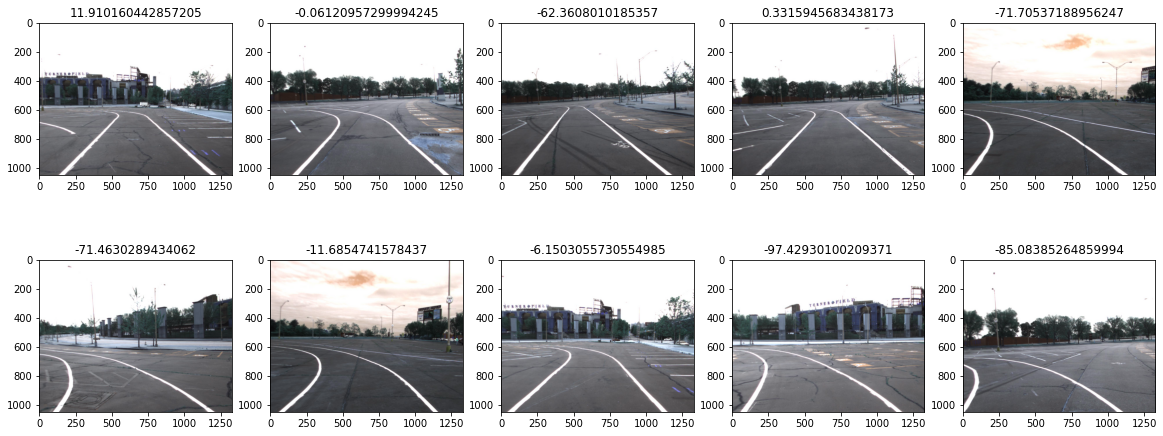

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import cv2

N = 10
random_images = random.choices(os.listdir(IMAGES_DIR), k=N)
rows=2
cols = 5

fig, axs = plt.subplots(rows, cols, figsize=(20,8))


for i, image_file in enumerate(random_images):
  row = i // cols
  col =  i % cols
  image_name = str(int(image_file.split('.')[0]))
  image_angle = image_angles[image_name]
  image_path = os.path.join(IMAGES_DIR, image_file)
  image = cv2.imread(image_path)
  axs[row, col].imshow(image)
  axs[row, col].set_title(image_angle)




#Instructions

Your mission is to train a neural network to steer a car using only image from a single camera. First you'll need to create a method to train your neural network:

In [ ]:
# def train(path_to_images, csv_file):
#     '''
#     First method you need to complete. 
#     Args: 
#     path_to_images = path to jpg image files
#     csv_file = path and filename to csv file containing frame numbers and steering angles. 
    
#     Returns: 
#     NN = Trained Neural Network object 
#     '''

Your method should return a trained neural network class. An example class (from the Neural Networks module) is also included in given. Your submitted script should also inlcude a NeuralNetwork() class - you are free to modify this class or write your own from scratch. You'll also need to create a predict method:

In [ ]:
# def predict(NN, image_file):
#     '''
#     Second method you need to complete. 
#     Given your trained neural network class, and an image filename, load image, make and return single predicted steering angle in degrees, as a float32. 
#     '''

# Scratch Space

Place to try things out....

# Your Code

In [ ]:
## ---------------------------- ##
##
## Example student submission code for autonomous driving challenge.
## You must modify the train and predict methods and the NeuralNetwork class. 
## 
## ---------------------------- ##

import numpy as np
import cv2
from tqdm import tqdm
import time

global maxVal
global minVal

maxVal = 0.0
minVal = 0.0

def preprocess(x):
  pass
  #return processed_x

def train(path_to_images = 'data/training/images', 
          csv_file = 'data/training/steering_angles.csv'):
    '''
    First method you need to complete. 
    Args: 
    path_to_images = path to jpg image files
    csv_file = path and filename to csv file containing frame numbers and steering angles. 
    Returns: 
    NN = Trained Neural Network object 
    '''

    # You may make changes here if you wish. 
    # Import Steering Angles CSV
    data = np.genfromtxt(csv_file, delimiter = ',')
    frame_nums = data[:,0]
    steering_angles = data[:,1]
    global maxVal 
    maxVal = np.amax(steering_angles, axis=0)
    global minVal 
    minVal = np.amin(steering_angles, axis=0)

    images = np.zeros((1500, 2500))
    print("Preprocessing....")
    for x in tqdm(range(len(frame_nums))):
        frame_num = int(frame_nums[x])
        im_full = cv2.imread(path_to_images + '/' + str(int(frame_num)).zfill(4) + '.jpg')
        grayscale = cv2.cvtColor(im_full, cv2.COLOR_BGR2GRAY)
        im_full = cv2.resize(grayscale, dsize =(50, 50))
        im_full = im_full.flatten()
        # Train your network here. You'll probably need some weights and gradients!
        images[x] = im_full / 255
        #im_full[im_full < threshold] = 0

    NN = NeuralNetwork(Lambda=0.001)
    params = NN.getParams()
    learning_rate = 0.3
    
    # normalize all steering angles
    for x in range(len(steering_angles)):
      steering_angles[x] = (steering_angles[x] - minVal) / (maxVal - minVal)

    # reshape so matrix multiplication can happen
    steering_angles = np.reshape(steering_angles, (1500, 1))

    # 10000 epochs
    print("Training....")
    for y in tqdm(range(10000)):

      # compute gradients
      dJdW1, dJdW2 = NN.computeGradients(images, steering_angles)
      
      # adjust weights
      NN.W1 = NN.W1 - learning_rate*dJdW1
      NN.W2 = NN.W2 - learning_rate*dJdW2
    
    # after training return the network
    return NN


def predict(NN, image_file):
    '''
    Second method you need to complete. 
    Given an image filename, load image, make and return predicted steering angle in degrees. 
    '''
    im_full = cv2.imread(image_file)
    # convert image to grayscale
    grayscale = cv2.cvtColor(im_full, cv2.COLOR_BGR2GRAY)
    # resize image
    im_full = cv2.resize(grayscale, dsize =(50, 50))
    # flatten image into a 2D array
    im_full = im_full.flatten()
    # normalize input
    im_full = im_full/255

    # predict steering angle
    yHat = NN.forward(np.reshape(im_full, (1,2500)))

    # undo normalization
    predict = (yHat[0][0] * (maxVal - minVal)) + minVal
    
    # return predicted angle
    return predict

class NeuralNetwork(object):
    def __init__(self, Lambda=0):        
        '''
        Neural Network Class, you may need to make some modifications here!
        '''
        self.inputLayerSize = 2500
        self.outputLayerSize = 1
        self.hiddenLayerSize = 30
        
        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)

        self.Lambda = Lambda
    
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        #print(self.z2.shape)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3) / X.shape[0] + self.Lambda*self.W2
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2) / X.shape[0] + self.Lambda*self.W1
        
        return dJdW1, dJdW2
    
    #Helper Functions for interacting with other classes:
    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single paramater vector.
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize , self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return dJdW1, dJdW2

#Evalution

Your code will be evaluated using evaluate.py, or a very similar variant. You can use this script locally to ensure you don't burn through your autograder submissions. Performance will be evaluated by comparing your predicted steering angles to human steering angles:



![](https://raw.githubusercontent.com/unccv/autonomous_driving/master/graphics/RMSE_Equation-01.png)


In [ ]:
import numpy as np
import cv2
from tqdm import tqdm
import time
import signal

def timeout_handler(num, stack):
    raise Exception("TIMEOUT")

def evaluate(path_to_training_images = 'data/training/images',
             training_csv_file = 'data/training/steering_angles.csv', 
             path_to_testing_images = 'data/training/images',
             testing_csv_file = 'data/training/steering_angles.csv', 
             time_limit = 600):
    
    '''
    Evaluate Student Submission for autonomous driving challenge. 
    Train and test studen't neural network implementation. 
    Training time is limited to time_limit seconds, if your code takes 
    longer than this, it will be terminated and no score will be recorded.
    '''
    
    
    #Setup timout handler - I think this will only work on unix based systems:
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(time_limit)
    
    try:
        print("Training your network, start time: %s" % time.strftime("%H:%M:%S"))
        NN = train(path_to_images = path_to_training_images,
                   csv_file = training_csv_file)
        
    finally:
        signal.alarm(0)
        print("Ending Time: %s" % time.strftime("%H:%M:%S"))
        
    print('Training Complete! \n')
    
    print('Measuring performance...')
    ## Measure Performance:
    data = np.genfromtxt(testing_csv_file, delimiter = ',')
    frame_nums = data[:,0]
    steering_angles = data[:,1]

    predicted_angles = []
    for frame_num in tqdm(frame_nums):
      im_path = path_to_testing_images + '/' + str(int(frame_num)).zfill(4) + '.jpg'
      predicted_angles.append(predict(NN, im_path))
        
    RMSE = np.sqrt(np.mean((np.array(predicted_angles)- steering_angles)**2))
    RMSE = round(RMSE, 3)
    print('Test Set RMSE = ' + str(RMSE) + ' degrees.')

    return RMSE

def calculate_score(RMSE):
    score = 0
    if RMSE <= 12.5:
        score = 10
    elif RMSE <= 15:
        score = 9
    elif RMSE <= 20:
        score = 8
    elif RMSE <= 25:
        score = 7
    elif RMSE <= 30:
        score = 6
    elif RMSE <= 40:
        score = 5
    else:
        score = 4
    return score


if __name__ == '__main__':
    program_start = time.time()
    RMSE = evaluate(path_to_training_images = 'data/training/images',
                    training_csv_file = 'data/training/steering_angles.csv', 
                    path_to_testing_images = 'data/training/images',
                    testing_csv_file = 'data/training/steering_angles.csv', 
                    time_limit = 600)
    
    score = calculate_score(RMSE)
    program_end = time.time()
    total_time = round(program_end - program_start,2)
    
    print("Execution time (seconds) = ", total_time)
    print("Score = ", score)


Training your network, start time: 19:04:31
Preprocessing....


100%|██████████| 1500/1500 [00:36<00:00, 41.08it/s]


(1500, 1)
(1500, 2500)
Training....


100%|██████████| 10000/10000 [08:49<00:00, 18.87it/s]


Ending Time: 19:13:58
Training Complete! 

Measuring performance...


100%|██████████| 1500/1500 [00:54<00:00, 27.70it/s]

Test Set RMSE = 10.054 degrees.
Execution time (seconds) =  620.73
Score =  10


##Run Time Limits

Due to limited compute capacity, your code will only be allowed to run for 10 minutes. Keep this in mind during development! There's lots of training strategies that take way too long, this time limit will force you to find nice fast training strategies (a useful skill, I promise). Finally, you may want to add your own timer to training to ensure you get as many training steps as you can without exceeding the time limit. If you exceed the time limit, your code will be termintated, and your submission will be scored as if your code fialed to run.

##Packages

For this challenge you are only permitted to use numpy, opencv, tdqm, time, and scipy. Tensorflow and other high level ML tools are not permitted.

##Grading



|RMSE (degrees) | Points (10 max) |
| ------------- |:-------------:| 
| RMSE <= 12.5       | 10/10 | 
| 12.5 < RMSE <= 15  | 9/10|  
| 15 < RMSE <= 20 | 8/10 |   
| 20 < RMSE <= 25 | 7/10 | 
| 25 < RMSE <= 30 | 6/10 | 
| 30 < RMSE <= 40 | 5/10 | 
| RMSE > 40, or code fails to run | 4/10 |
